Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[INFO] Loaded Qwen/Qwen2.5-3B-Instruct on cuda


Prompts:  20%|██        | 1/5 [00:00<00:01,  2.50it/s]

[INFO] Saved gradient norms for prompt 1


Prompts:  40%|████      | 2/5 [00:00<00:01,  2.28it/s]

[INFO] Saved gradient norms for prompt 2


Prompts:  60%|██████    | 3/5 [00:01<00:00,  2.29it/s]

[INFO] Saved gradient norms for prompt 3


Prompts:  80%|████████  | 4/5 [00:01<00:00,  2.30it/s]

[INFO] Saved gradient norms for prompt 4


Prompts: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

[INFO] Saved gradient norms for prompt 5
[INFO] Gradient extraction complete → gradients/


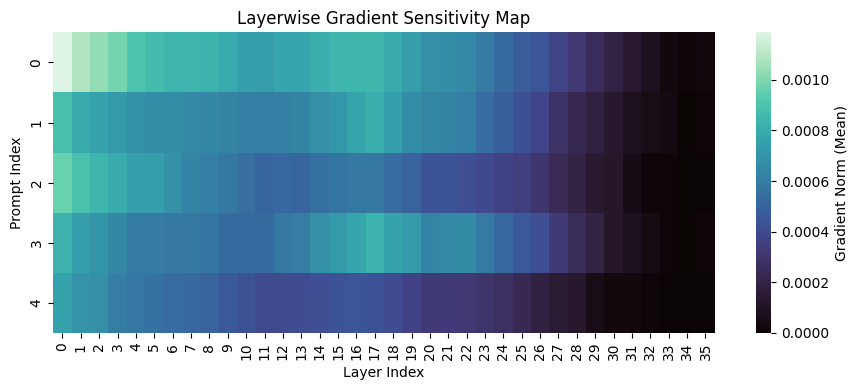

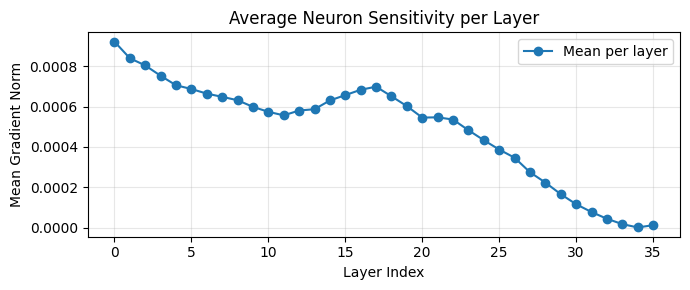

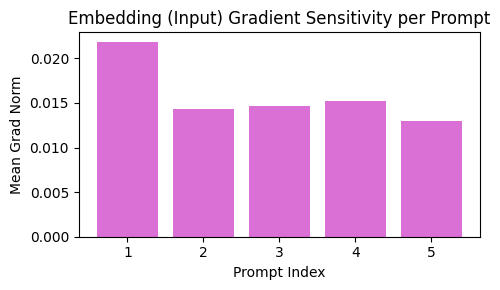

In [5]:
#!/usr/bin/env python3
"""
Phase 5 — Activation-Gradient Sensitivity Mapping
Computes per-layer gradient norms (‖∂logits / ∂hidden_i‖)
for each prompt to identify which layers and neurons are most
sensitive to semantic perturbations.
"""

import os, json, torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

# ---------------------------------------------------------------------
# 1 — Model Load and Device
# ---------------------------------------------------------------------
def load_model(model_name="Qwen/Qwen2.5-3B-Instruct"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        device_map="auto"
    )
    model.eval()
    print(f"[INFO] Loaded {model_name} on {device}")
    return model, tokenizer, device

# ---------------------------------------------------------------------
# 2 — Hook Registration (for Gradients)
# ---------------------------------------------------------------------
def register_backward_hooks(model, grad_store):
    """Attach backward hooks to capture gradient w.r.t. hidden states."""
    handles = []
    for idx, layer in enumerate(model.model.layers):
        def hook_fn(module, grad_input, grad_output, layer_idx=idx):
            grad_store[layer_idx] = grad_output[0].detach().cpu()
        handles.append(layer.register_full_backward_hook(hook_fn))
    return handles

# ---------------------------------------------------------------------
# 3 — Gradient Computation
# ---------------------------------------------------------------------
def compute_gradients(model, tokenizer, device, prompts, save_dir="gradients"):
    """
    Compute per-layer gradient norms for each prompt.
    Uses embedding gradients (∂logits/∂embeddings) as signal source.
    """
    os.makedirs(save_dir, exist_ok=True)
    grad_store = {}

    # Register backward hooks on transformer layers
    hooks = register_backward_hooks(model, grad_store)

    # Get the model's word embedding layer
    embed_layer = model.get_input_embeddings()
    embed_grads = []

    def emb_hook(module, grad_input, grad_output):
        embed_grads.append(grad_output[0].detach().cpu())

    emb_handle = embed_layer.register_full_backward_hook(emb_hook)

    for p_idx, prompt in enumerate(tqdm(prompts, desc="Prompts")):
        embed_grads.clear()
        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        model.zero_grad(set_to_none=True)
        outputs = model(**inputs)

        # Compute mean over logits as proxy scalar objective
        scalar = outputs.logits.mean()
        scalar.backward()

        # Collect layer gradients (norms)
        for layer_idx, grad_tensor in grad_store.items():
            grad_norm = grad_tensor.pow(2).mean(dim=-1).sqrt().mean(dim=0).numpy()
            np.save(f"{save_dir}/prompt{p_idx+1:02d}_layer{layer_idx:02d}_gradnorm.npy", grad_norm)

        # Also save embedding gradient norms (input-level sensitivity)
        if embed_grads:
            emb_norm = embed_grads[0].pow(2).mean(dim=-1).sqrt().mean(dim=0).numpy()
            np.save(f"{save_dir}/prompt{p_idx+1:02d}_embedding_gradnorm.npy", emb_norm)

        print(f"[INFO] Saved gradient norms for prompt {p_idx+1}")

    for h in hooks:
        h.remove()
    emb_handle.remove()

    print(f"[INFO] Gradient extraction complete → {save_dir}/")



# ---------------------------------------------------------------------
# 4 — Visualization
# ---------------------------------------------------------------------
def plot_layerwise_gradients(base_dir="gradients"):
    """
    Loads all *_gradnorm.npy files and visualizes layerwise sensitivity.
    Handles both per-layer and embedding-level files.
    """
    files = sorted([f for f in os.listdir(base_dir) if f.endswith("_gradnorm.npy")])
    if not files:
        raise FileNotFoundError("No gradnorm files found — run compute_gradients first.")

    # Separate embedding vs layer files
    layer_files = [f for f in files if "_layer" in f]
    emb_files = [f for f in files if "_embedding" in f]

    layers = sorted({int(f.split("_layer")[1].split("_")[0]) for f in layer_files})
    prompts = sorted({int(f.split("prompt")[1].split("_")[0]) for f in files})

    # Aggregate mean gradient norm per layer × prompt
    data = np.zeros((len(prompts), len(layers)))
    for i, p in enumerate(prompts):
        for j, l in enumerate(layers):
            path = f"{base_dir}/prompt{p:02d}_layer{l:02d}_gradnorm.npy"
            if os.path.exists(path):
                data[i, j] = np.load(path).mean()

    # ------------- Heatmap -------------
    plt.figure(figsize=(9,4))
    sns.heatmap(data, cmap="mako", cbar_kws={'label':'Gradient Norm (Mean)'})
    plt.xlabel("Layer Index")
    plt.ylabel("Prompt Index")
    plt.title("Layerwise Gradient Sensitivity Map")
    plt.tight_layout()
    plt.show()

    # ------------- Average Curve -------------
    mean_per_layer = data.mean(axis=0)
    plt.figure(figsize=(7,3))
    plt.plot(layers, mean_per_layer, marker="o", label="Mean per layer")
    plt.xlabel("Layer Index")
    plt.ylabel("Mean Gradient Norm")
    plt.title("Average Neuron Sensitivity per Layer")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ------------- Optional Embedding Gradients -------------
    if emb_files:
        emb_values = []
        for f in emb_files:
            emb_values.append(np.load(os.path.join(base_dir, f)).mean())
        plt.figure(figsize=(5,3))
        plt.bar(range(1, len(emb_values)+1), emb_values, color="orchid")
        plt.xlabel("Prompt Index")
        plt.ylabel("Mean Grad Norm")
        plt.title("Embedding (Input) Gradient Sensitivity per Prompt")
        plt.tight_layout()
        plt.show()


# ---------------------------------------------------------------------
# 5 — Main
# ---------------------------------------------------------------------
def main():
    # Load latest recommender log for prompt text
    log_dir = "logs"
    log_files = sorted([f for f in os.listdir(log_dir) if f.startswith("recommender_") and f.endswith(".json")])
    if not log_files:
        raise FileNotFoundError("No recommender_*.json logs found.")
    latest_log = os.path.join(log_dir, log_files[-1])
    with open(latest_log, "r", encoding="utf-8") as f:
        data = json.load(f)
    prompts = [r["question"] for r in data["records"]]

    model, tokenizer, device = load_model()
    compute_gradients(model, tokenizer, device, prompts)
    plot_layerwise_gradients()

if __name__ == "__main__":
    main()


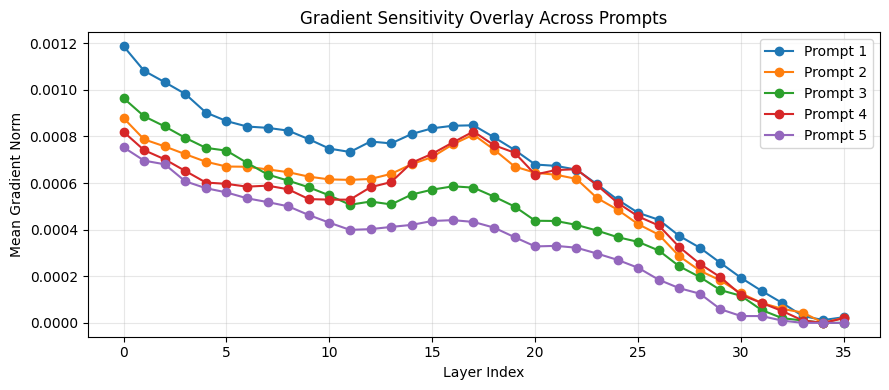

In [6]:
# ---------------------------------------------------------------------
# 6 — Multi-Prompt Overlay of Gradient Norm Curves
# ---------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import os

base_dir = "gradients"

# Collect available prompts and layers
files = sorted([f for f in os.listdir(base_dir) if "_layer" in f and f.endswith("_gradnorm.npy")])
prompts = sorted({int(f.split("prompt")[1].split("_")[0]) for f in files})
layers = sorted({int(f.split("_layer")[1].split("_")[0]) for f in files})

plt.figure(figsize=(9, 4))

for p in prompts:
    grad_curve = []
    for l in layers:
        path = f"{base_dir}/prompt{p:02d}_layer{l:02d}_gradnorm.npy"
        if os.path.exists(path):
            grad_curve.append(np.load(path).mean())
        else:
            grad_curve.append(np.nan)
    plt.plot(layers, grad_curve, marker="o", label=f"Prompt {p}")

plt.xlabel("Layer Index")
plt.ylabel("Mean Gradient Norm")
plt.title("Gradient Sensitivity Overlay Across Prompts")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
